### 1. Imports

In [81]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### 1.2 Import the data

In [82]:
path = 'dataset/A_DeviceMotion_data/'

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

for i in list_of_directories:
    if i == path + '.DS_Store':
        continue

    list_of_csv = os.listdir(i)
    list_of_csv = [m for m in list_of_csv if m.endswith('.csv')]
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[2].split('_')[0]
        k['trial'] = int(i.split('/')[2].split('_')[1])
        
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)

df = pd.concat(list_of_dfs, ignore_index=True).set_index('time')

df.head()

,accel_x,accel_y,accel_z,accel_norm,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject,activity,trial
time,,,,,,,,,,,,,,,,,,,
0,-0.122085,0.626434,-0.161957,0.658448,-2.116381,-1.077507,-2.261502,-0.404768,0.880780,0.245713,-1.264215,-1.027909,-0.947909,0.282683,-0.254346,-0.407670,12,dws,11
1,-0.160369,0.946457,-0.288605,1.002393,-2.148154,-1.049759,-2.284278,-0.417081,0.867303,0.271686,-1.162024,-0.269118,-0.848823,0.256712,0.079154,-0.560291,12,dws,11
2,-0.178482,1.202301,-0.178314,1.228487,-2.153824,-1.026749,-2.297008,-0.432082,0.855621,0.284961,-0.665042,0.520170,-0.726722,0.253600,0.346680,-0.463275,12,dws,11
3,-0.033493,1.307663,-0.223786,1.327096,-2.142509,-1.012749,-2.290595,-0.445311,0.848291,0.286507,-0.079809,0.055322,-0.604534,0.411818,0.459372,-0.510293,12,dws,11
4,-0.141067,1.322677,-0.641449,1.476764,-2.130486,-1.007262,-2.274149,-0.452661,0.845372,0.283600,0.456097,-0.186877,-0.441315,0.311594,0.477305,-0.925049,12,dws,11


In [83]:

# combine dfs and drop unnecessary columns
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

df.head()

df_X = df.iloc[:, :-3]
df_y = df.iloc[:, -3:]

print(df_X.head())
print()
print(df_y.head())

       accel_x   accel_y   accel_z  accel_norm    gyro_x    gyro_y    gyro_z
time                                                                        
0    -0.122085  0.626434 -0.161957    0.658448 -1.264215 -1.027909 -0.947909
1    -0.160369  0.946457 -0.288605    1.002393 -1.162024 -0.269118 -0.848823
2    -0.178482  1.202301 -0.178314    1.228487 -0.665042  0.520170 -0.726722
3    -0.033493  1.307663 -0.223786    1.327096 -0.079809  0.055322 -0.604534
4    -0.141067  1.322677 -0.641449    1.476764  0.456097 -0.186877 -0.441315

      subject activity  trial
time                         
0          12      dws     11
1          12      dws     11
2          12      dws     11
3          12      dws     11
4          12      dws     11


### 1.3 Data Preprocessing

##### 1.3.1 Data scaling

In [84]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def minmax_scaling(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

def standard_scaling(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

##### 1.3.2 Graph the best number of components to use

In [85]:
from sklearn.decomposition import PCA

def pca_best_components(df):
    X = df.iloc[:,:-3]
    normalized_X = (X - X.mean()) / X.std()
    # apply PCA
    pca = PCA()
    pca.fit(normalized_X)

    explained_variance = pca.explained_variance_ratio_

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance))
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Number of Components')
    plt.title('Explained Variance by Principal Components')
    plt.grid()
    plt.show()

    # find the number of components that explain 95% of the variance
    cumsum = np.cumsum(explained_variance)
    best_n_components = np.argmax(cumsum >= 0.95) + 1
    print("Best number of components:", best_n_components)
    return best_n_components

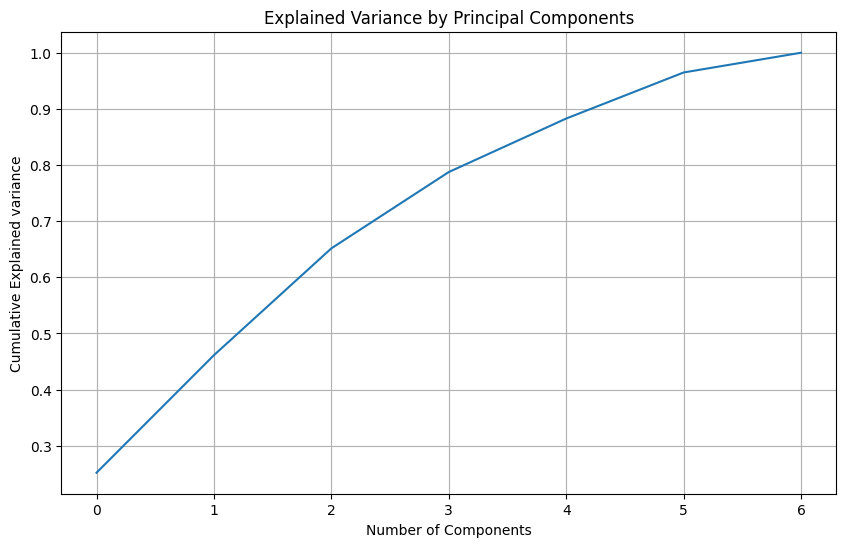

Best number of components: 6


In [86]:
best_n_c = pca_best_components(df)

if best_n_c == len(df_X.columns):
    print("PCA not needed")

#### 1.3.3 Simple Test train split

In [87]:
train_df = df[(df.trial < 10)]
test_df = df[(df.trial >= 10)]

# all except last 3 cols (activity, subject, trial)
X = train_df.iloc[:,:-3]
y = train_df.activity

### 1.3 Data Analysis

1.3.1 Decision Tree

In [88]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X, y)

DecisionTreeClassifier()

In [89]:
def test_results(model, df, scaling_func=None):
    correct = 0
    total = 0

    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        if scaling_func:
            k = scaling_func(k)
        preds = model.predict(k)
        print(i + ': ' + str(((preds == i).sum() / len(preds))*100) + '%')
        correct += (preds == i).sum()
        total += len(preds)
    print('Total: ' + str((correct / total)*100) + '%')

In [90]:
test_results(dtc, test_df)

dws: 39.51204337392232%
ups: 43.03973722731979%
sit: 99.08760000384169%
std: 92.07459778706301%
wlk: 58.26081627650448%
jog: 58.343365436062065%
Total: 76.86191799504554%


### 1.3.1.1 Decision Tree with scaling

In [93]:
dtc = DecisionTreeClassifier()
X_scaled = minmax_scaling(X)
dtc.fit(X_scaled, y)

test_results(dtc, test_df, minmax_scaling)

dws: 7.8215269753799666%
ups: 9.718304830590167%
sit: 0.0%
std: 0.0%
wlk: 17.33821546758181%
jog: 48.47512038523274%
Total: 9.140996744302528%


In [94]:
dtc = DecisionTreeClassifier()
X_scaled = standard_scaling(X)
dtc.fit(X_scaled, y)

test_results(dtc, test_df, standard_scaling)

dws: 31.752733090391967%
ups: 29.968938555464312%
sit: 13.720575100123893%
std: 11.575645439952947%
wlk: 53.597254565510475%
jog: 18.395532370251473%
Total: 24.065307058436602%


### 2.2 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X, y)

In [ ]:
test_results(rfc, test_df)

dws: 47.16469647142476%
ups: 47.227676818165584%
sit: 99.47080800222817%
std: 93.58419820857482%
wlk: 67.77484985905136%
jog: 67.22177635098984%
Total: 80.90242261306683%
